In [51]:
%matplotlib inline

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import scipy.io as sio


In [52]:
data = np.load("data_img.npy")
labels = np.load("labels_img.npy")
# labels = np.load("correct.npy")[0]
rewarded = np.load("rewarded.npy")[0]

In [53]:
labels[:10]

array([1., 1., 2., 2., 2., 2., 2., 1., 2., 1.])

# Build decoder

In [54]:
%matplotlib inline
import os
import yaml
import matplotlib.gridspec as gridspec
import math
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [55]:
# from tensorboardX import SummaryWriter
# from torchvision import datasets, transforms
# from torchvision.utils import make_grid
from tqdm import tqdm, trange

# writer = SummaryWriter()
# sns.set()
# sns.set_style("dark")
# sns.set_palette("muted")
# sns.set_color_codes("muted")

In [56]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

True


In [57]:
BATCH_SIZE = 64
CLASSES = 2
TRAIN_EPOCHS = 100



In [58]:
decision_data = data[~np.isnan(labels)]
decision_labels = labels[~np.isnan(labels)]

In [59]:
rewarded_updated = rewarded[~np.isnan(labels)]

In [60]:
decision_data = decision_data.reshape((decision_data.shape[0], 1, decision_data.shape[1], decision_data.shape[2]))

In [61]:
decision_labels = decision_labels - 1

In [62]:
training_samples = 500
idx = np.random.choice(training_samples, training_samples, replace = False)

In [63]:
train_data = torch.tensor(decision_data[:training_samples]) #idx#training_samples
tensor_train_labels = torch.tensor(decision_labels[:training_samples])
test_data = torch.tensor(decision_data[training_samples:])
tensor_test_labels = torch.tensor(decision_labels[training_samples:])

In [64]:
torch_train_dataset = torch.utils.data.TensorDataset(train_data, tensor_train_labels)
train_loader = torch.utils.data.DataLoader(torch_train_dataset, batch_size=BATCH_SIZE)
torch_test_dataset = torch.utils.data.TensorDataset(test_data, tensor_test_labels)
test_loader = torch.utils.data.DataLoader(torch_test_dataset, batch_size=BATCH_SIZE)

In [65]:
TRAIN_SIZE = len(train_loader.dataset)
NUM_BATCHES = len(train_loader)

In [66]:
NUM_BATCHES

8

In [67]:
class Net(nn.Module):   
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 3, kernel_size=(9, 3), stride=(3, 1), padding=3),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
#             nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(3),
#             nn.Tanh(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(3),
#             nn.Tanh(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers1 = nn.Sequential(
            nn.Linear(975, 64), 
            nn.Tanh(),
            nn.Linear(64, 4), 
            nn.Tanh()
        )
        
        self.W1_1 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
        )

        self.W1_2 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
        )

        self.W1_3 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
        )
        
        self.W1_4 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
        )

        self.linear_layers2 = nn.Sequential(
            nn.Linear(4, 32), 
            nn.Tanh(),
#             nn.Linear(32, 32), 
#             nn.Tanh(),
            nn.Linear(32, 2), 
            # Dimension?
            nn.Softmax(dim = 1)
        )

    # Defining the forward pass    
    def forward(self, x):
#         print(self.cnn_layers[0](x).shape)
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers1(x)
        x = self.W1_1(x)
        x = self.linear_layers2(x)
        return x
    
    def forward_with_state(self, x, state):
#         print(self.cnn_layers[0](x).shape)
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers1(x)
        if state == 0:
            x = self.W1_1(x)
        elif state == 1:
            x = self.W1_2(x)
        elif state == 2:
            x = self.W1_3(x)
        elif state == 3:
            x = self.W1_4(x)
        x = self.linear_layers2(x)
        return x

In [75]:
def train(model, optimizer, epoch, l2_regularization = True):
#     model.train()

    #     if epoch == 0: # write initial distributions
    #         write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate((train_loader)):
        target = target.long()
        optimizer.zero_grad()
        output_val = model(data)
        loss = criterion(output_val, target)
        if l2_regularization:
            l2_reg = torch.tensor(0.)
            for idx, param in enumerate(model.parameters()):
                #idx != 12 and idx != 13 and 
                if idx != 14 and idx != 15 and idx != 16 and idx != 17 and idx != 18 and idx != 19:
                    l2_reg += 0.0005*torch.norm(param)
            loss += l2_reg
        loss.backward()
        optimizer.step()
    return loss


In [76]:
# for idx, param in enumerate(model.parameters()):
#     print(idx)
#     print(param)

In [77]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# defining the loss function
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 3, kernel_size=(9, 3), stride=(3, 1), padding=(3, 3))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers1): Sequential(
    (0): Linear(in_features=975, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=4, bias=True)
    (3): Tanh()
  )
  (W1_1): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Tanh()
  )
  (W1_2): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Tanh()
  )
  (W1_3): Sequential(
    (0): Linear(in_features=4, 

In [78]:
TRAIN_EPOCHS = 100
loss_overtime = []
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.25)
for epoch in tqdm(range(TRAIN_EPOCHS)):
    loss  = train(model, optimizer, epoch, l2_regularization = True)
    loss_overtime.append(loss.detach().numpy())
    if epoch % 5 == 0:
        plt.figure(figsize = (10, 10))
        plt.plot(loss_overtime)
        plt.grid()
        plt.savefig("loss_overtime.png")
        plt.close()
    if (epoch+1) % 10 == 0:
        scheduler.step()
#         for param_group in optimizer.param_groups:
#             print(param_group['lr'])

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


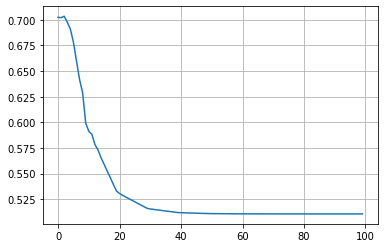

In [79]:
plt.plot(loss_overtime)
plt.grid()

In [80]:
####### evaluate on train 

model.eval()
train_loss = 0
predict_train = []
true_value = []
for batch_idx, (data, target) in enumerate((train_loader)):
    output_val = model(data)
    train_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
    for k in output_val.detach().numpy().argmax(1):
        predict_train.append(k)
    for k in target.detach().numpy():
        true_value.append(k)

train_loss = train_loss/TRAIN_SIZE
print(train_loss)

0.026


In [81]:
model.eval()
test_loss = 0
predict_test = []
true_value = []
for batch_idx, (data, target) in tqdm(enumerate((test_loader))):
    output_val = model(data)
    for k in output_val.detach().numpy().argmax(1):
        predict_test.append(k)
    for k in target.detach().numpy():
        true_value.append(k)
    test_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
test_loss = test_loss/len(test_loader.dataset)
print(test_loss)

1it [00:00, 53.15it/s]

0.16666666666666666


In [ ]:
len(train_loader)

# Initialize model for HMM

In [ ]:
### Initialize W1_bis 

W_mat = model.W1[0].weight.data.detach().numpy().copy()
bias_mat = model.W1[0].bias.data.detach().numpy().copy()

model.W1_bis[0].weight.data = torch.from_numpy(W_mat)
model.W1_bis[0].bias.data = torch.from_numpy(bias_mat)

In [ ]:
model.W1[0].weight.data

In [ ]:
model.W1_bis[0].weight.data

In [82]:
### Set all gradients to False except W1, W1_bis

# for idx, params in enumerate(model.parameters()):
#     print(idx)
#     if idx == 12 or idx == 13 or idx == 14 or idx == 15:
#         params.requires_grad = True
#     else :
#         params.requires_grad = False
#     print(params) # prints two True statements?

model.W1_1 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
           )

model.W1_2 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
           )


model.W1_3 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
           )


model.W1_4 = nn.Sequential(
            nn.Linear(4, 4), 
            nn.Tanh()
           )


# model.W1_bis = nn.Sequential(
#             nn.Linear(4, 4), 
#             nn.Tanh()
#            )

In [83]:
## train batch_size = 1 for easy access

BATCH_SIZE = 1
train_loader = torch.utils.data.DataLoader(torch_train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(torch_test_dataset, batch_size=BATCH_SIZE)

In [84]:
len(train_loader)

500

# GLM HMM Layer Changes

In [86]:
### Initialize parameters 

NUM_ITER_EM = 25
N_ITER_GD = 20 #20
n_states = 2
n_steps = 500
phi = np.ones(n_states)/n_states
ALPHA = 1
alpha = ALPHA*np.ones(n_states)
A = np.random.dirichlet(alpha, size = n_states)
# A = np.zeros((n_states, n_states))
# A[0] = np.random.dirichlet(alpha, size = 1)[0]
# A[1, 0] = A[0, 1]
# A[1, 1] = A[0, 0]
A

array([[0.13492505, 0.86507495],
       [0.54762061, 0.45237939]])

In [87]:
a = np.zeros((n_steps, n_states))

In [99]:
A

array([[0.17023644, 0.82976356],
       [0.61139132, 0.38860868]])

In [89]:
### E step

def forward_a(A, phi, model):
#     print("Forward Step")
    a = np.zeros((n_steps, n_states))
#     model.eval() Set it before calling function
    for batch_idx, (data, target) in tqdm(enumerate((train_loader))):
        true_label = int(target.detach().cpu().numpy()[0])
        if batch_idx == 0:
            for i in range(n_states):
                a[batch_idx, i] = phi[i]*model.forward_with_state(data, i).detach().cpu().numpy()[0, true_label]
#                 a[batch_idx, 1] = phi[1]*model.forward_with_state(data, 1).detach().cpu().numpy()[0, true_label]
        else :
            for i in range(n_states):
                val = model.forward_with_state(data, i).detach().cpu().numpy()[0, true_label]
                for j in range(n_states):
                    a[batch_idx, i] += A[j, i]*a[batch_idx-1, j]*val
#             a[batch_idx, 1] = (A[1, 1]*a[batch_idx-1, 1] + A[0, 1]*a[batch_idx-1, 0])*model.forward_with_state(data, 1).detach().cpu().numpy()[0, true_label]
    del data
    del target
    return a


def backward_b(A, model):
    print("Backward Step")
    b = np.zeros((n_steps, n_states))
    for batch_idx, (data, target) in tqdm(reversed(list(enumerate(train_loader)))):
        if batch_idx == n_steps-1:
            for i in range(n_states):
                b[batch_idx, i] = 1
#             b[batch_idx, 1] = 1
        else :
            for i in range(n_states):
                for j in range(n_states):
                    b[batch_idx, i] += A[i, j]*b[batch_idx+1, j]*model.forward_with_state(data_previous, j).detach().cpu().numpy()[0, true_label_previous]
#             b[batch_idx, 0] = A[0, 0]*b[batch_idx+1, 0]*model.forward_with_state(data_previous, 0).detach().cpu().numpy()[0, true_label_previous] + A[0, 1]*b[batch_idx+1, 1]*model.forward_with_state(data_previous, 1).detach().cpu().numpy()[0, true_label_previous]
#             b[batch_idx, 1] = A[1, 1]*b[batch_idx+1, 1]*model.forward_with_state(data_previous, 1).detach().cpu().numpy()[0, true_label_previous] + A[1, 0]*b[batch_idx+1, 0]*model.forward_with_state(data_previous, 0).detach().cpu().numpy()[0, true_label_previous]
        data_previous = data
        true_label_previous = int(target.detach().cpu().numpy()[0])
    del data
    del target
    del data_previous
    del true_label_previous
    return b

def calculate_gamma(a, b):
    return np.multiply(a, b)/(a[-1].sum())

def calculate_xi(a, b, A, model):
    xi = np.zeros((n_steps-1, n_states, n_states))
    for batch_idx, (data, target) in tqdm(reversed(list(enumerate(train_loader)))):
        if batch_idx>0:
            true_label = int(target.detach().cpu().numpy()[0])
            for i in range(n_states):
                for j in range(n_states):
                    xi[batch_idx-1, i, j] = a[batch_idx-1, i]*A[i, j]*b[batch_idx, j]*model.forward_with_state(data, j).detach().cpu().numpy()[0, true_label]
#             xi[batch_idx-1, 0, 0] = a[batch_idx-1, 0]*A[0, 0]*b[batch_idx, 0]*model.forward_with_state(data, 0).detach().cpu().numpy()[0, true_label]
#             xi[batch_idx-1, 1, 0] = a[batch_idx-1, 1]*A[1, 0]*b[batch_idx, 0]*model.forward_with_state(data, 0).detach().cpu().numpy()[0, true_label]
#             xi[batch_idx-1, 0, 1] = a[batch_idx-1, 0]*A[0, 1]*b[batch_idx, 1]*model.forward_with_state(data, 1).detach().cpu().numpy()[0, true_label] 
#             xi[batch_idx-1, 1, 1] = a[batch_idx-1, 1]*A[1, 1]*b[batch_idx, 1]*model.forward_with_state(data, 1).detach().cpu().numpy()[0, true_label]
    del data
    del target
    return xi/(a[n_steps-1].sum())

In [90]:
### M step

def update_phi(gamma):
    return gamma[0]/(gamma[0].sum())

def update_A(xi):
    for i in range(n_states):
        for j in range(n_states):
            A[i, j] = (ALPHA-1 + xi[:, i, j].sum())/(n_states*(ALPHA - 1) + xi[:, i, :].sum())

#     A[0, 0] = (ALPHA-1 + xi[:, 0, 0].sum())/(n_states*(ALPHA - 1) + xi[:, 0, :].sum())
#     A[1, 0] = (ALPHA-1 + xi[:, 1, 0].sum())/(n_states*(ALPHA - 1) + xi[:, 1, :].sum())
#     A[0, 1] = (ALPHA-1 + xi[:, 0, 1].sum())/(n_states*(ALPHA - 1) + xi[:, 0, :].sum())
#     A[1, 1] = (ALPHA-1 + xi[:, 1, 1].sum())/(n_states*(ALPHA - 1) + xi[:, 1, :].sum())
    return A

In [91]:
def update_wi(model, gamma):
    print("Update W_i")
    for epoch_optim in tqdm(range(N_ITER_GD)):
        optimizer.zero_grad()
        loss = 0
        for batch_idx, (data, target) in enumerate((train_loader)):
            true_label = int(target.detach().cpu().numpy()[0])
            for j in range(n_states):
                loss -= torch.log(model.forward_with_state(data, j)[0, true_label])*gamma[batch_idx, j]
#                 loss -= model.forward_with_state(data, 1)[0, true_label]*gamma[batch_idx, 1]
#         print("LOSS: ")
#         print(loss)
        loss.backward()
        optimizer.step()
        #     print("difference gamma : ")
        #     print(gamma_before - gamma)
        loss_numpy = loss.detach().cpu().numpy()
        del loss
    return loss_numpy

In [92]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_overtime = []
loss_1_overtime = []
loss_2_overtime = []
loss_3_overtime = []

for iter in range(5):
    # E step
    print("E step")
    model.eval()
    a = forward_a(A, phi, model)
    b = backward_b(A, model)
    gamma = calculate_gamma(a, b)
    xi = calculate_xi(a, b, A, model)
    
    # M step
    print("M step")
    phi = update_phi(gamma)
    A = update_A(xi)
    
    model.train()
    for idx, params in enumerate(model.parameters()):
        if idx == 12 or idx == 13 or idx == 14 or idx == 15 or idx == 16 or idx == 17 or idx == 18 or idx == 19:
            params.requires_grad = True
        else :
            params.requires_grad = False
    loss_1 = (gamma[0]*phi).sum()
    loss_2 = (xi*np.log(A)).sum()
    loss_3 = update_wi(model, gamma)
    
    loss_1_overtime.append(loss_1)
    loss_2_overtime.append(loss_2)
    loss_3_overtime.append(loss_3)
    loss_overtime.append(loss_1 + loss_2 + loss_3) 

36it [00:00, 352.67it/s]

E step


500it [00:01, 389.73it/s]
22it [00:00, 216.57it/s]

Backward Step


500it [00:02, 230.38it/s]
500it [00:02, 233.57it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

M step
Update W_i


100%|██████████| 20/20 [00:35<00:00,  1.80s/it]
27it [00:00, 265.53it/s]

E step


500it [00:01, 289.65it/s]
17it [00:00, 164.01it/s]

Backward Step


500it [00:03, 153.66it/s]
500it [00:02, 166.98it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

M step
Update W_i


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]
25it [00:00, 244.55it/s]

E step


500it [00:01, 451.68it/s]
27it [00:00, 266.98it/s]

Backward Step


500it [00:01, 251.06it/s]
500it [00:02, 249.72it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

M step
Update W_i


100%|██████████| 20/20 [00:35<00:00,  1.76s/it]
31it [00:00, 303.56it/s]

E step


500it [00:01, 434.02it/s]
28it [00:00, 270.92it/s]

Backward Step


500it [00:01, 252.71it/s]
500it [00:02, 246.91it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

M step
Update W_i


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]
29it [00:00, 289.39it/s]

E step


500it [00:01, 438.66it/s]
27it [00:00, 268.41it/s]

Backward Step


500it [00:01, 251.02it/s]
500it [00:01, 252.65it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

M step
Update W_i


100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


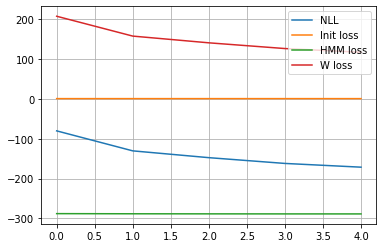

In [93]:
plt.plot(loss_overtime, label = "NLL")
plt.plot(loss_1_overtime, label = "Init loss")
plt.plot(loss_2_overtime, label = "HMM loss")
plt.plot(loss_3_overtime, label = "W loss")
plt.grid()
plt.legend()

In [94]:
gamma.argmax(1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
np.where(abs(np.asarray(predict_train) - np.asarray(true_value)) != 0)

In [ ]:
np.where(abs(np.asarray(predict_train) - np.asarray(true_value)) != 0)[0]

In [ ]:
rewarded[[353, 492]]
gamma.argmax(1)[[353, 492]]

In [ ]:
rewarded[np.where(abs(np.asarray(predict_test) - np.asarray(true_value)) != 0)[0]]

In [95]:

model.eval()
train_loss = 0
predict_train = []
true_value = []
for batch_idx, (data, target) in enumerate((train_loader)):
    output_val = model.forward_with_state(data, gamma[batch_idx].argmax())
    train_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
    for k in output_val.detach().numpy().argmax(1):
        predict_train.append(k)
    for k in target.detach().numpy():
        true_value.append(k)

train_loss = train_loss/TRAIN_SIZE
print(train_loss)

0.03


In [96]:
np.where(abs(np.asarray(predict_train) - np.asarray(true_value)) != 0)[0]

array([ 41,  45, 145, 147, 156, 176, 247, 299, 305, 323, 380, 439, 480,
       485, 495])

In [98]:
model.eval()
test_loss = 0
predict_test = []
true_value = []
for batch_idx, (data, target) in tqdm(enumerate((test_loader))):
    output_val = model.forward_with_state(data, 1)
    for k in output_val.detach().numpy().argmax(1):
        predict_test.append(k)
    for k in target.detach().numpy():
        true_value.append(k)
    test_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
test_loss = test_loss/len(test_loader.dataset)
print(test_loss)

48it [00:00, 528.58it/s]

0.14583333333333334


In [ ]:
model.W1[0].weight.data

In [ ]:
model.W1_bis[0].weight.data

In [ ]:
model.W1[0].bias.data

In [ ]:
model.W1_bis[0].bias.data

In [ ]:
gamma.argmax(1)

# Train one model per state 

In [36]:
model1 = Net()
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)

model2 = Net()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

model3 = Net()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

model4 = Net()
optimizer4 = optim.Adam(model4.parameters(), lr=0.0001)

models = [model1, model2, model3, model4]
optimizers = [optimizer1, optimizer2, optimizer3, optimizer4]

In [37]:
### Initialize parameters 

NUM_ITER_EM = 50
N_ITER_GD = 200 #20
n_states = 4
n_steps = 500
phi = np.ones(n_states)/n_states
ALPHA = 1
alpha = ALPHA*np.ones(n_states)
A = np.random.dirichlet(alpha, size = n_states)
# A = np.zeros((n_states, n_states))
# A[0] = np.random.dirichlet(alpha, size = 1)[0]
# A[1, 0] = A[0, 1]
# A[1, 1] = A[0, 0]
A

array([[0.27943741, 0.56633578, 0.04657944, 0.10764737],
       [0.72415172, 0.10307846, 0.09641941, 0.07635042],
       [0.16273262, 0.04156565, 0.70858164, 0.08712009],
       [0.09608835, 0.17022776, 0.56533379, 0.16835009]])

In [38]:
### E step

def forward_a(A, phi, models):
#     print("Forward Step")
    a = np.zeros((n_steps, n_states))
#     model.eval() Set it before calling function
    for batch_idx, (data, target) in tqdm(enumerate((train_loader))):
        true_label = int(target.detach().cpu().numpy()[0])
        if batch_idx == 0:
            for i in range(n_states):
                models[i].eval()
                a[batch_idx, i] = phi[i]*models[i](data).detach().cpu().numpy()[0, true_label]
#                 a[batch_idx, 1] = phi[1]*model.forward_with_state(data, 1).detach().cpu().numpy()[0, true_label]
        else :
            for i in range(n_states):
                models[i].eval()
                val = models[i](data).detach().cpu().numpy()[0, true_label]
                for j in range(n_states):
                    a[batch_idx, i] += A[j, i]*a[batch_idx-1, j]*val
#             a[batch_idx, 1] = (A[1, 1]*a[batch_idx-1, 1] + A[0, 1]*a[batch_idx-1, 0])*model.forward_with_state(data, 1).detach().cpu().numpy()[0, true_label]
    del data
    del target
    return a


def backward_b(A, models):
    print("Backward Step")
    b = np.zeros((n_steps, n_states))
    for batch_idx, (data, target) in tqdm(reversed(list(enumerate(train_loader)))):
        if batch_idx == n_steps-1:
            for i in range(n_states):
                b[batch_idx, i] = 1
#             b[batch_idx, 1] = 1
        else :
            for j in range(n_states):
                models[j].eval()
                for i in range(n_states):
                    b[batch_idx, i] += A[i, j]*b[batch_idx+1, j]*models[j](data_previous).detach().cpu().numpy()[0, true_label_previous]
#             b[batch_idx, 0] = A[0, 0]*b[batch_idx+1, 0]*model.forward_with_state(data_previous, 0).detach().cpu().numpy()[0, true_label_previous] + A[0, 1]*b[batch_idx+1, 1]*model.forward_with_state(data_previous, 1).detach().cpu().numpy()[0, true_label_previous]
#             b[batch_idx, 1] = A[1, 1]*b[batch_idx+1, 1]*model.forward_with_state(data_previous, 1).detach().cpu().numpy()[0, true_label_previous] + A[1, 0]*b[batch_idx+1, 0]*model.forward_with_state(data_previous, 0).detach().cpu().numpy()[0, true_label_previous]
        data_previous = data
        true_label_previous = int(target.detach().cpu().numpy()[0])
    del data
    del target
    del data_previous
    del true_label_previous
    return b

def calculate_gamma(a, b):
    return np.multiply(a, b)/(a[-1].sum())

def calculate_xi(a, b, A, models):
    xi = np.zeros((n_steps-1, n_states, n_states))
    for batch_idx, (data, target) in tqdm(reversed(list(enumerate(train_loader)))):
        if batch_idx>0:
            true_label = int(target.detach().cpu().numpy()[0])
            for j in range(n_states):
                models[j].eval()
                for i in range(n_states):
                    xi[batch_idx-1, i, j] = a[batch_idx-1, i]*A[i, j]*b[batch_idx, j]*models[j](data).detach().cpu().numpy()[0, true_label]
    del data
    del target
    return xi/(a[n_steps-1].sum())

In [39]:
### M step

def update_phi(gamma):
    return gamma[0]/(gamma[0].sum())

def update_A(xi):
    for i in range(n_states):
        for j in range(n_states):
            A[i, j] = (ALPHA-1 + xi[:, i, j].sum())/(n_states*(ALPHA - 1) + xi[:, i, :].sum())
    return A

In [40]:
def train_with_gamma(model, optimizer, state, gamma, N_EPOCHS):
    model.train()
    for epoch in range(N_EPOCHS):
        optimizer.zero_grad()
        loss = 0
        #     if epoch == 0: # write initial distributions
        #         write_weight_histograms(epoch)
        for batch_idx, (data, target) in enumerate((train_loader)):
            true_label = int(target.detach().cpu().numpy()[0])
            optimizer.zero_grad()
            loss -= torch.log(model(data)[0, true_label])*gamma[batch_idx, state]
        loss.backward()
        optimizer.step()
        return loss

def update_wi(models, optimizers, gamma, N_EPOCHS):
    loss_wi = 0
    for i in tqdm(range(n_states)):
        loss_wi += train_with_gamma(models[i], optimizers[i], i, gamma, N_EPOCHS)
    return loss_wi

In [41]:
loss_overtime = []
loss_1_overtime = []
loss_2_overtime = []
loss_3_overtime = []

for iter in range(10):
    # E step
    print("E step")
#     model.eval()
    a = forward_a(A, phi, models)
    b = backward_b(A, models)
    gamma = calculate_gamma(a, b)
    xi = calculate_xi(a, b, A, models)
    
    # M step
    print("M step")
    phi = update_phi(gamma)
    A = update_A(xi)

    loss_1 = (gamma[0]*phi).sum()
    loss_2 = (xi*np.log(A)).sum()
    loss_3 = update_wi(models, optimizers, gamma, N_ITER_GD)
    
    loss_1_overtime.append(loss_1)
    loss_2_overtime.append(loss_2)
    loss_3_overtime.append(loss_3)
    loss_overtime.append(loss_1 + loss_2 + loss_3) 

23it [00:00, 224.61it/s]

E step


500it [00:02, 233.78it/s]
8it [00:00, 75.45it/s]

Backward Step


500it [00:09, 55.09it/s]
500it [00:09, 51.69it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]
13it [00:00, 125.31it/s]

E step


500it [00:03, 152.57it/s]
5it [00:00, 46.79it/s]

Backward Step


500it [00:08, 57.07it/s]
500it [00:11, 41.71it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]
12it [00:00, 117.96it/s]

E step


500it [00:02, 206.04it/s]
8it [00:00, 72.47it/s]

Backward Step


500it [00:09, 52.30it/s]
500it [00:09, 52.32it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]
13it [00:00, 127.62it/s]

E step


500it [00:02, 211.31it/s]
8it [00:00, 71.84it/s]

Backward Step


500it [00:08, 60.54it/s]
500it [00:08, 59.57it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]
13it [00:00, 126.36it/s]

E step


500it [00:02, 199.63it/s]
5it [00:00, 46.53it/s]

Backward Step


500it [00:08, 59.61it/s]
500it [00:08, 60.43it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]
12it [00:00, 119.66it/s]

E step


500it [00:03, 132.91it/s]
5it [00:00, 46.37it/s]

Backward Step


500it [00:09, 50.18it/s]
500it [00:12, 40.61it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]
11it [00:00, 108.41it/s]

E step


500it [00:03, 139.43it/s]
5it [00:00, 46.81it/s]

Backward Step


500it [00:11, 45.08it/s]
500it [00:08, 58.42it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]
13it [00:00, 126.33it/s]

E step


500it [00:03, 160.59it/s]
5it [00:00, 46.08it/s]

Backward Step


500it [00:13, 37.53it/s]
500it [00:08, 59.22it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:08<00:00,  2.01s/it]
10it [00:00, 97.69it/s]

E step


500it [00:03, 142.98it/s]
5it [00:00, 46.46it/s]

Backward Step


500it [00:11, 43.27it/s]
500it [00:12, 40.30it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]
13it [00:00, 123.24it/s]

E step


500it [00:03, 136.03it/s]
8it [00:00, 70.35it/s]

Backward Step


500it [00:08, 60.50it/s]
500it [00:10, 45.72it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

M step


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


In [44]:
gamma

array([[0.66868501, 0.232818  , 0.07689209, 0.0216049 ],
       [0.41768224, 0.39442205, 0.11038733, 0.07750838],
       [0.42315171, 0.30993246, 0.15746853, 0.1094473 ],
       ...,
       [0.35978475, 0.27249142, 0.25854011, 0.10918373],
       [0.35462583, 0.27360023, 0.25762759, 0.11414635],
       [0.38318218, 0.25407207, 0.27961859, 0.08312716]])

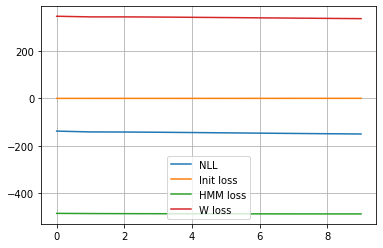

In [43]:
plt.plot(loss_overtime, label = "NLL")
plt.plot(loss_1_overtime, label = "Init loss")
plt.plot(loss_2_overtime, label = "HMM loss")
plt.plot(loss_3_overtime, label = "W loss")
plt.grid()
plt.legend()

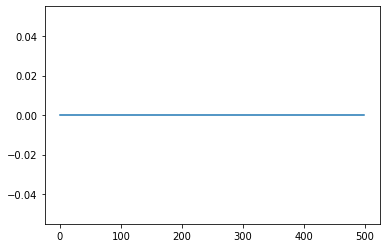

In [45]:
plt.plot(gamma.argmax(1))

In [50]:
A

array([[0.4484802 , 0.3969222 , 0.03782475, 0.11677284],
       [0.50366374, 0.43963946, 0.00561458, 0.05108222],
       [0.2191567 , 0.42150249, 0.32715042, 0.03219038],
       [0.14794917, 0.28974025, 0.39682272, 0.16548785]])

In [ ]:
update_A(xi)

In [51]:

model.eval()
train_loss = 0
predict_train = []
true_value = []
for batch_idx, (data, target) in enumerate((train_loader)):
    output_val = models[gamma[batch_idx].argmax()](data)
    train_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
    for k in output_val.detach().numpy().argmax(1):
        predict_train.append(k)
    for k in target.detach().numpy():
        true_value.append(k)

train_loss = train_loss/TRAIN_SIZE
print(train_loss)

0.0


In [56]:
model.eval()
test_loss = 0
predict_test = []
true_value = []
for batch_idx, (data, target) in tqdm(enumerate((test_loader))):
    output_val = models[0](data)
    for k in output_val.detach().numpy().argmax(1):
        predict_test.append(k)
    for k in target.detach().numpy():
        true_value.append(k)
    test_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
test_loss = test_loss/len(test_loader.dataset)
print(test_loss)

48it [00:00, 643.52it/s]

0.5208333333333334
